In [725]:
import pandas as pd
import numpy as np
import random
import torch
from statsmodels.datasets import get_rdataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import time
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math


Using my own time series generator to create sales data of winter jackets between 1/1/2012 to 12/31/2022:
- Creates a basic pattern of seasonal effect (ie sales will be higher in the winter months, so add higher multipliers for those motnhs in season_effect array)
- Sales for each month calculated based on this seasonal pattern
- linearly increasing trend added to suimulate business growth
- random noise added to make it more realistic/add unpreccitability
- .clip() method to make sure there are no negative values, which could happen due to noise


In [726]:
# original time period (around 10 years)
start_date = '2012-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M') #monthly

In [727]:
#make it a dataframe
sales_data = pd.DataFrame(index=date_range)

In [728]:
# synthetic time series generation: simulate seasonal effect
# since the data is sales of winter coats, there will be higher sales in the winter months (November to February)
#create seasonal pattern over the year
seasonal_effect = np.array([1.2, 1.5, 1.7, 1.5, 1.2, 1, 0.8, 0.7, 0.8, 1, 1.2, 1.5])

# apply seasonal effect to each year
sales_data['sales'] = [1000 * seasonal_effect[month] for year in range(2012, 2023) for month in range(12)]

# add a general increasing trend over years like most businesses have
trend = np.linspace(1, 1.3, len(sales_data))
sales_data['sales'] *= trend

# add random noise to simulate real world data
noise = np.random.normal(0, 50, len(sales_data))
sales_data['sales'] += noise

# round the sales numbers and ensure no negative values
sales_data['sales'] = sales_data['sales'].round().clip(lower=0)

#check everthing looks ok, .head() should start in 2012
print(sales_data.head())

             sales
2012-01-31  1196.0
2012-02-29  1428.0
2012-03-31  1561.0
2012-04-30  1553.0
2012-05-31  1240.0


In [729]:
print(sales_data.shape)

(132, 1)


In [730]:
#reshape data
#this makes it into 2d array for input to pytorch models
data = sales_data['sales'].values.astype(float).reshape(-1, 1)  # Reshape for single feature

In [731]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

In [732]:
#create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(data_normalized, train_window)

# convert sequences to PyTorch tensors
train_inout_seq = [(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for x, y in train_inout_seq]

# dataLoader
batch_size = 1
train_loader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=False)

In [733]:

#LSTM model from pytorch
class LSTMmodel(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        #lstm
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


In [734]:
# prepare the test data (use last 12 points (months in 2022) as test data) because predicting sales each month over the year 2022
test_data = data_normalized[-(train_window+12):]
test_inout_seq = create_inout_sequences(test_data, train_window)

# convert sequences to PyTorch tensors
test_inout_seq = [(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for x, y in test_inout_seq]

# dataLoader for test data
test_loader = DataLoader(test_inout_seq, batch_size=1, shuffle=False)


In [735]:
#function to train model
def train_model(model, train_loader, epochs):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(epochs):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

In [736]:
epochs = 1
# create instance of lstm model
lstm_model = LSTMmodel()

In [737]:
#train model and evaluate
#start time
lstm_start = time.time()
# call training function
train_model(lstm_model, train_loader, epochs)

#evaluate model
lstm_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = lstm_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
lstm_end = time.time()
lstm_duration = lstm_end - lstm_start
print(f"LSTM model duration: {lstm_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.02629412
LSTM model duration: 0.3457052707672119


In [738]:
#calc performance metrics
lstm_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
lstm_rmse = math.sqrt(lstm_mse)
print(f'MSE: {lstm_mse}, RMSE: {lstm_rmse} seconds')

MSE: 392700.49462164944, RMSE: 626.6581960061238 seconds


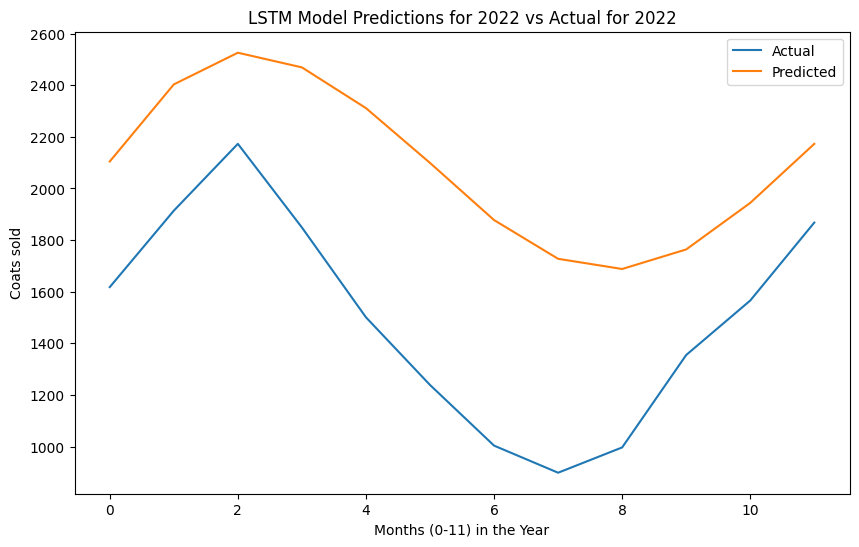

In [739]:
#plotting predicitons for last year 2022 based on model predictions on data against actual 2022 data
#this is over the course of a year, monthly
plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('LSTM Model Predictions for 2022 vs Actual for 2022')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats sold')
plt.legend()
plt.show()


GRU - Gated Recurrent Unit

In [740]:
#define GRU model
class GRUmodel(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1):
        super(GRUmodel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        #add in gru
        self.gru = nn.GRU(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        hidden_cell = torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device)
        gru_out, _ = self.gru(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1]


In [741]:
#create instance of gru model
gru_model = GRUmodel()

In [742]:
#train and test gru
#start time
gru_start = time.time()
# call training function
train_model(gru_model, train_loader, epochs)

#evaluate model
gru_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = gru_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
gru_end = time.time()
gru_duration = gru_end - gru_start
print(f"GRU model duration: {gru_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.01268419
GRU model duration: 0.2906925678253174


In [743]:
#calc performance metrics
gru_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
gru_rmse = math.sqrt(gru_mse)
print(f'MSE: {gru_mse}, RMSE: {gru_rmse}')

MSE: 23152.262553098088, RMSE: 152.15867557618293


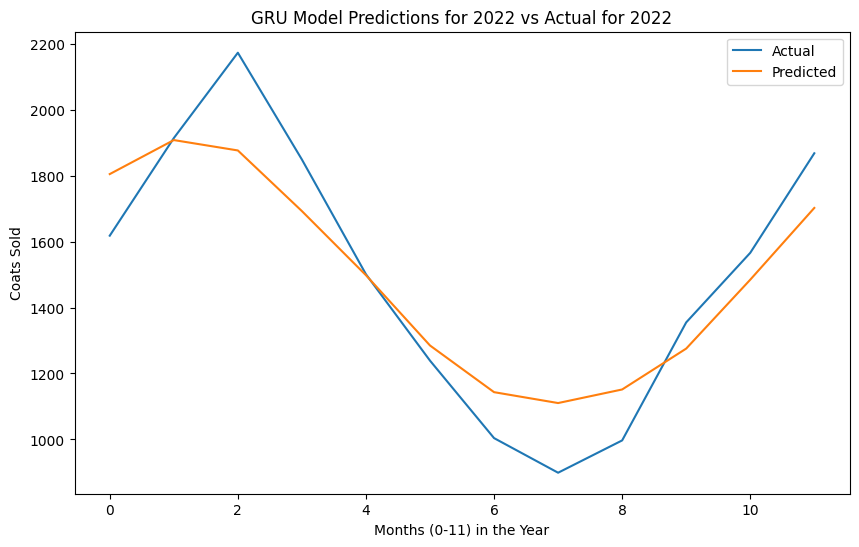

In [744]:
#plotting predicitons
plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('GRU Model Predictions for 2022 vs Actual for 2022')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

Bidirectional GRU RNN

In [745]:
#define bidirectional gru model
class BiGRUmodel(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, output_size=1):
        super(BiGRUmodel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        # set bidirectional=True to make it bi
        self.gru = nn.GRU(input_size, hidden_layer_size, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)  # adjust for bidirectional output

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # initialize hidden state with correct dimensions for the bidirectional model
        hidden_cell = torch.zeros(2, batch_size, self.hidden_layer_size).to(input_seq.device)
        gru_out, _ = self.gru(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1]


In [746]:
epochs = 1
# instance of bi model
bi_model = BiGRUmodel()

In [747]:
#start time for bi_model
bi_start = time.time()
# call training function
train_model(bi_model, train_loader, epochs)

#evaluate model
bi_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = bi_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
bi_end = time.time()
bi_duration = bi_end - bi_start
print(f"Bi GRU model duration: {bi_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00376811
Bi GRU model duration: 0.41624951362609863


In [748]:
#calc performance metrics
bi_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
bi_rmse = math.sqrt(bi_mse)
print(f'MSE: {bi_mse}, RMSE: {bi_rmse}')

MSE: 14404.59202657795, RMSE: 120.01913191894845


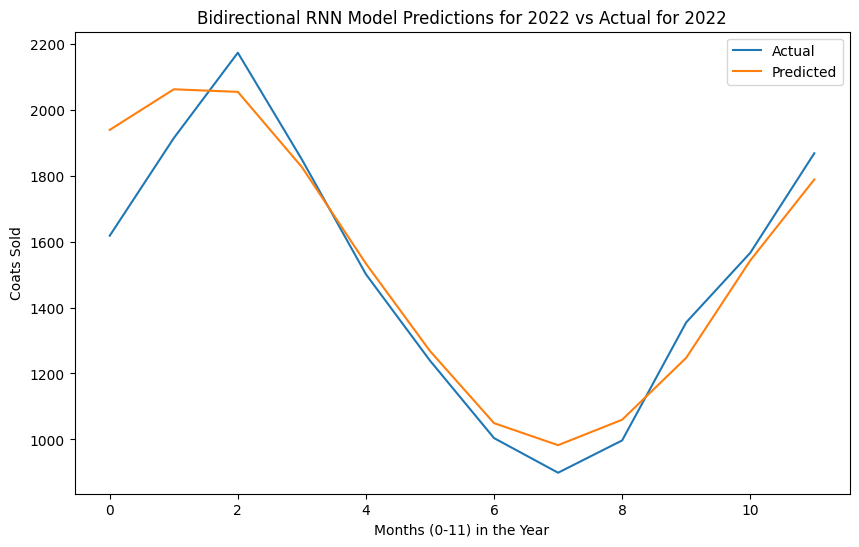

In [749]:
#plot pred for bi model
plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Bidirectional RNN Model Predictions for 2022 vs Actual for 2022')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

Deep RNN
- has multiple reccurent layers

In [750]:
#deep RNN
class DeepGRUmodel(nn.Module):
    def __init__(self, input_size=12, hidden_layer_size=100, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        #add multiple stacked gru layers
        self.gru_layers = nn.ModuleList([
            nn.GRU(input_size if i == 0 else hidden_layer_size, hidden_layer_size)
            for i in range(num_layers)
        ])
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cells = [torch.zeros(1, 1, hidden_layer_size) for _ in range(num_layers)]

    def forward(self, input_seq):
        for i in range(self.num_layers):
            # detach the hidden state from the computation graph
            hidden_cell_detached = self.hidden_cells[i].detach()
            gru_out, self.hidden_cells[i] = self.gru_layers[i](
                input_seq.view(len(input_seq), 1, -1), hidden_cell_detached
            )
            input_seq = gru_out

        #final layer output is predictions
        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1]


In [751]:
epochs = 1
# instance of deep gru rnn
deep_model = DeepGRUmodel()

In [752]:
#start time for deep model
deep_start = time.time()
# call training function
train_model(deep_model, train_loader, epochs)

#evaluate model
deep_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = deep_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
deep_end = time.time()
deep_duration = deep_end - deep_start
print(f"Deep GRU model duration: {deep_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00000286
Deep GRU model duration: 0.37921714782714844


In [753]:
#calc performance metrics
deep_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
deep_rmse = math.sqrt(deep_mse)
print(f'MSE: {deep_mse}, RMSE: {deep_rmse}')

MSE: 76985.7601542415, RMSE: 277.4630789028362


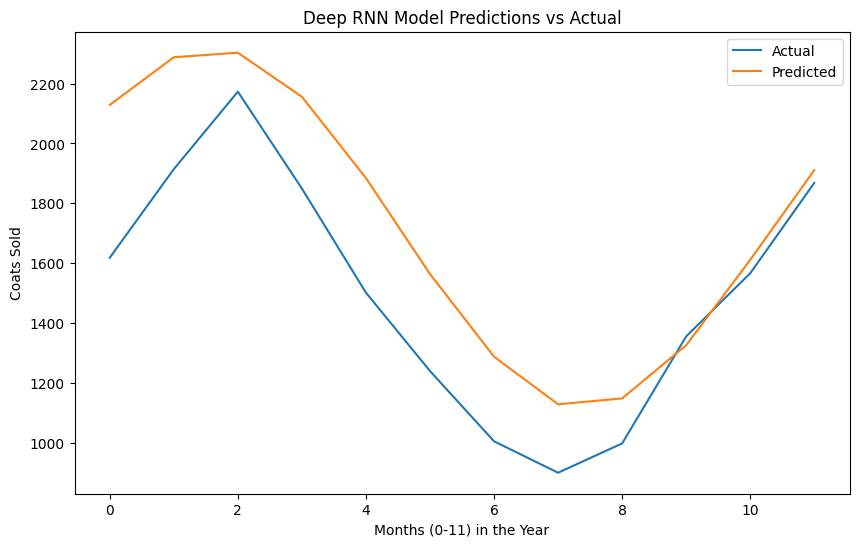

In [754]:
#plot pred

plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Deep RNN Model Predictions vs Actual')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

3. Increase size of the time series three times and peform the ecperiments in step 2

In [755]:
#increase the size of the time series data to be 3 times as large
#original data was 10 years long, so to make it 3x as large, I will make the dataset 30 years long
# define the new extended (3x) time period (now around 30 years)
start_date = '1992-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
# create df
large_sales_data = pd.DataFrame(index=date_range)

In [756]:
#same thing as before
# simulate seasonal effect - higher sales in the winter months
seasonal_effect = np.array([1.2, 1.5, 1.7, 1.5, 1.2, 1, 0.8, 0.7, 0.8, 1, 1.2, 1.5])

# apply seasonal effect to each year
large_sales_data['sales'] = [1000 * seasonal_effect[month] for year in range(1992, 2023) for month in range(12)]

# add a general increasing trend over years
trend = np.linspace(1, 1.3, len(large_sales_data))
large_sales_data['sales'] *= trend

# add some random noise
noise = np.random.normal(0, 50, len(large_sales_data))
large_sales_data['sales'] += noise

# round the sales numbers and ensure no negative values
large_sales_data['sales'] = large_sales_data['sales'].round().clip(lower=0)

print(large_sales_data.head()) #should now start 1992

             sales
1992-01-31  1207.0
1992-02-29  1509.0
1992-03-31  1695.0
1992-04-30  1504.0
1992-05-31  1247.0


In [757]:
print(large_sales_data.tail()) #shuld start 2022

             sales
2022-08-31   914.0
2022-09-30  1055.0
2022-10-31  1249.0
2022-11-30  1591.0
2022-12-31  1947.0


In [758]:
#reshape data
#this makes it into 2d array for input to pytorch models
data = large_sales_data['sales'].values.astype(float).reshape(-1, 1)  # Reshape for single feature

In [759]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

In [760]:
print(len(large_sales_data))

372


LSTM on 3x larger data

In [761]:
train_window = 12
#create sequences on 3x larger
train_inout_seq = create_inout_sequences(data_normalized, train_window)

# convert sequences to PyTorch tensors
train_inout_seq = [(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for x, y in train_inout_seq]

# dataloader
batch_size = 1
train_loader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=False)

In [762]:
#prepare the test data (use last 12 points as test data)
# assuming you're using the last 12 points as test data
test_data = data_normalized[-(train_window+12):]

test_inout_seq = create_inout_sequences(test_data, train_window)

# convert sequences to PyTorch tensors
test_inout_seq = [(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for x, y in test_inout_seq]

# dataLoader for test data
test_loader = DataLoader(test_inout_seq, batch_size=1, shuffle=False)

In [763]:
epochs = 1

# large lstm model
large_lstm_model = LSTMmodel()

In [764]:
large_lstm_start = time.time()
# call the training function
train_model(large_lstm_model, train_loader, epochs)

#evaluate modle
large_lstm_model.eval()  # Set the model to evaluation mode

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = large_lstm_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
large_lstm_end = time.time()
large_lstm_duration = large_lstm_end - large_lstm_start
print(f"Large LSTM model duration: {large_lstm_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.03211024
Large LSTM model duration: 0.7299284934997559


In [765]:
#calc performance metrics
large_lstm_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
large_lstm_rmse = math.sqrt(large_lstm_mse)
print(f'3x Larger Data MSE: {large_lstm_mse}, RMSE: {large_lstm_rmse}')

3x Larger Data MSE: 457094.50639154384, RMSE: 676.0876469745205


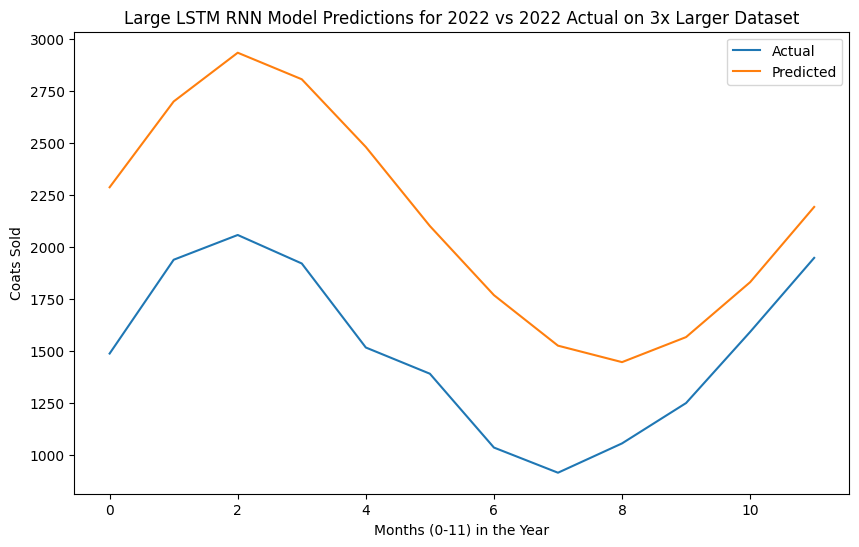

In [766]:
#plot pred for lstm on 3x data

plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Large LSTM RNN Model Predictions for 2022 vs 2022 Actual on 3x Larger Dataset')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

GRU on 3x data

In [767]:
epochs = 1
# instantiate your model
large_gru_model = GRUmodel()

In [768]:
#start time
large_gru_start = time.time()
# call the training function
train_model(large_gru_model, train_loader, epochs)

#evaluate model
large_gru_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = large_gru_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
large_gru_end = time.time()
large_gru_duration = large_gru_end - large_gru_start
print(f"Large GRU model duration: {large_gru_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.03070093
Large GRU model duration: 0.5617094039916992


In [769]:
#calc performance metrics
large_gru_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
large_gru_rmse = math.sqrt(large_gru_mse)
print(f'MSE: {large_gru_mse}, RMSE: {large_gru_rmse}')

MSE: 18032.31650932704, RMSE: 134.28446116110024


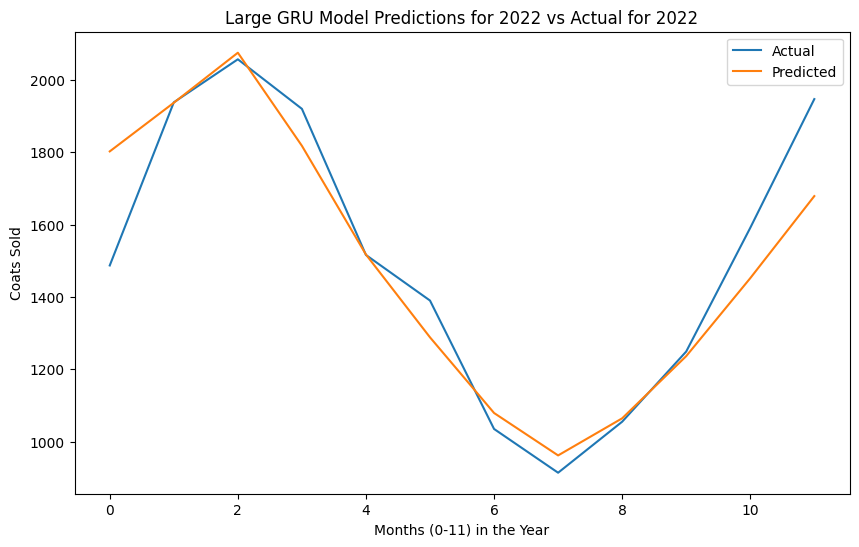

In [770]:
#plotting predicitons for large gru
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Large GRU Model Predictions for 2022 vs Actual for 2022')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

Large Bidrectional GRU RNN

In [771]:
epochs = 1
large_bi_model = BiGRUmodel()

In [772]:
#start time for large bi_model
large_bi_start = time.time()
# call the training function
train_model(large_bi_model, train_loader, epochs)

#evaluate model
large_bi_model.eval()

test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = large_bi_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
large_bi_end = time.time()
large_bi_duration = large_bi_end - large_bi_start
print(f"Bi GRU model duration: {large_bi_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.02792562
Bi GRU model duration: 0.847611665725708


In [773]:
#calc performance metrics
large_bi_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
large_bi_rmse = math.sqrt(large_bi_mse)
print(f'MSE: {large_bi_mse}, RMSE: {large_bi_rmse}')

MSE: 15355.341379834084, RMSE: 123.91667111343044


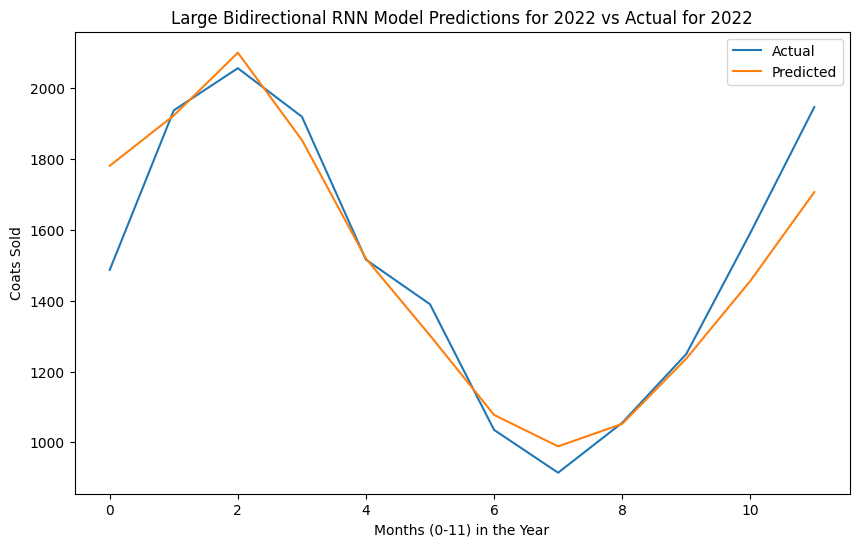

In [774]:
#plot pred for large bi
plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Large Bidirectional RNN Model Predictions for 2022 vs Actual for 2022')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

Deep RNN

In [775]:
epochs = 1
large_deep_model = DeepGRUmodel()

In [776]:
#start time for deep_model
large_deep_start = time.time()
# call training function
train_model(large_deep_model, train_loader, epochs)

#evaluate model
large_deep_model.eval()
test_predictions = []
test_actual = []

with torch.no_grad():
    for seq, labels in test_loader:
        y_pred = large_deep_model(seq)
        test_predictions.append(y_pred.item())
        test_actual.append(labels.item())

# rescale predictions back to the original scale
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_actual_rescaled = scaler.inverse_transform(np.array(test_actual).reshape(-1, 1))
large_deep_end = time.time()
large_deep_duration = large_deep_end - large_deep_start
print(f"Large Deep GRU model duration: {large_deep_duration}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.08572266
Large Deep GRU model duration: 0.7916576862335205


In [777]:
#calc performance metrics
large_deep_mse = mean_squared_error(test_actual_rescaled, test_predictions_rescaled)
large_deep_rmse = math.sqrt(large_deep_mse)
print(f'MSE: {large_deep_mse}, RMSE: {large_deep_rmse}')

MSE: 48916.02557796357, RMSE: 221.1696759909992


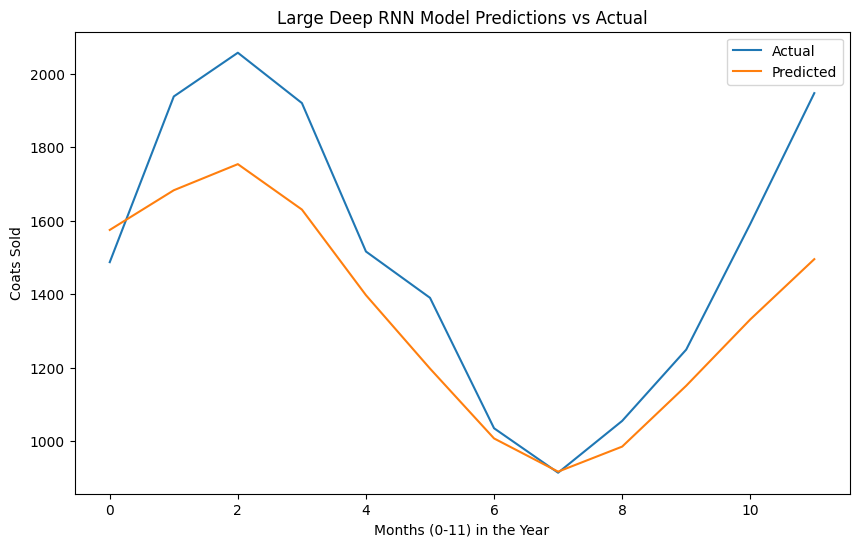

In [778]:
#plot pred
plt.figure(figsize=(10, 6))
plt.plot(test_actual_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('Large Deep RNN Model Predictions vs Actual')
plt.xlabel('Months (0-11) in the Year')
plt.ylabel('Coats Sold')
plt.legend()
plt.show()

In [779]:
#now compare the duration and rmse for each model on normal data

model_dic = {"Small Model": ['LSTM','GRU','Bi RNN','Deep RNN'], "RMSE":[lstm_rmse,gru_rmse,bi_rmse,deep_rmse], 'Duration': [lstm_duration,gru_duration,bi_duration,deep_duration]}
model_df = pd.DataFrame(model_dic)

In [780]:
print(model_df)

  Small Model        RMSE  Duration
0        LSTM  626.658196  0.345705
1         GRU  152.158676  0.290693
2      Bi RNN  120.019132  0.416250
3    Deep RNN  277.463079  0.379217


In [781]:
#now compare the duration and rmse for each model on large data

large_model_dic = {"Large Model": ['LSTM','GRU','Bi RNN','Deep RNN'], "RMSE":[large_lstm_rmse,large_gru_rmse,large_bi_rmse,large_deep_rmse], 'Duration': [large_lstm_duration,large_gru_duration,large_bi_duration,large_deep_duration]}
large_model_df = pd.DataFrame(large_model_dic)
print(large_model_df)

  Large Model        RMSE  Duration
0        LSTM  676.087647  0.729928
1         GRU  134.284461  0.561709
2      Bi RNN  123.916671  0.847612
3    Deep RNN  221.169676  0.791658
